## 4. Train and prediction with Amazon Forecast

In this notebook, we train an Amazon Forecast model with the processed data then make prediction for 1 week, Forecast Horizon. Then again we save the prediction for comparison laster.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import boto3

In [18]:
# https://github.com/aws-samples/amazon-forecast-samples/blob/main/notebooks/common/util/notebook_utils.py
import sys
import io
import ipywidgets
class StatusIndicator:
    
    def __init__(self):
        self.previous_status = None
        self.need_newline = False
        
    def update( self, status ):
        if self.previous_status != status:
            if self.need_newline:
                sys.stdout.write("\n")
            sys.stdout.write( status + " ")
            self.need_newline = True
            self.previous_status = status
        else:
            sys.stdout.write(".")
            self.need_newline = True
        sys.stdout.flush()

    def end(self):
        if self.need_newline:
            sys.stdout.write("\n")

# https://github.com/aws-samples/amazon-forecast-samples/blob/main/notebooks/common/util/fcst_utils.py
import time
def wait(callback, time_interval = 10):

    status_indicator = util.notebook_utils.StatusIndicator()

    while True:
        status = callback()['Status']
        status_indicator.update(status)
        if status in ('ACTIVE', 'CREATE_FAILED'): break
        time.sleep(time_interval)

    status_indicator.end()
    
    return (status=="ACTIVE")


In [33]:
#session = boto3.Session(region_name='ap-northeast2')
session = boto3.Session(region_name='us-east-1')
forecast = session.client(service_name='forecast')
forecastquery = session.client(service_name='forecastquery')
iam_client = session.client('iam')
role = iam_client.get_role(RoleName='ForecastNotebookRole-Basic')
role_arn = role['Role']['Arn']

In [ ]:
my_bucket_name = "s3://[my bucket name]"

In [6]:
#data_path = 
df = pd.read_csv(f"{my_bucket_name}/nyc-taxi-trip-data-to-fit/df_sel.csv", 
                       index_col=0, parse_dates=[1], infer_datetime_format=True)

In [7]:
df

,PULocationID,count
pickup_time,,
2020-11-01 00:00:00,48,132
2020-11-01 00:00:00,132,15
2020-11-01 00:00:00,142,31
2020-11-01 00:00:00,161,18
2020-11-01 00:00:00,162,24
...,...,...
2022-12-01 12:00:00,236,1
2022-12-01 14:00:00,162,1
2022-12-01 15:00:00,162,1


In [8]:
df = df.rename(columns={"PULocationID":"item_id", "count":"target_value"})
df.index.names = ["timestamp"]


In [9]:
df

,item_id,target_value
timestamp,,
2020-11-01 00:00:00,48,132
2020-11-01 00:00:00,132,15
2020-11-01 00:00:00,142,31
2020-11-01 00:00:00,161,18
2020-11-01 00:00:00,162,24
...,...,...
2022-12-01 12:00:00,236,1
2022-12-01 14:00:00,162,1
2022-12-01 15:00:00,162,1


In [40]:
df_train = df.loc[:'2022-10-31 23:59:00']
df_test = df.loc['2022-11-01 00:00:00':'2022-11-07 23:59:00']

In [11]:
df_train

,item_id,target_value
timestamp,,
2020-11-01 00:00:00,48,132
2020-11-01 00:00:00,132,15
2020-11-01 00:00:00,142,31
2020-11-01 00:00:00,161,18
2020-11-01 00:00:00,162,24
...,...,...
2022-10-31 23:00:00,170,72
2022-10-31 23:00:00,186,116
2022-10-31 23:00:00,230,112


In [12]:
df_test

,item_id,target_value
timestamp,,
2022-11-01 00:00:00,48,101
2022-11-01 00:00:00,132,165
2022-11-01 00:00:00,142,26
2022-11-01 00:00:00,161,44
2022-11-01 00:00:00,162,29
...,...,...
2022-11-07 23:00:00,170,106
2022-11-07 23:00:00,186,128
2022-11-07 23:00:00,230,169


In [44]:
df_train_path_name = f"{my_bucket_name}/nyc-taxi-trip-data-to-fit/forecast_train_data.csv"
df_train.to_csv(df_train_path_name)
df_test_path_name = f"{my_bucket_name}/nyc-taxi-trip-data-to-fit/forecast_test_data.csv"
df_test.to_csv(df_test_path_name)

In [19]:

# create a dataset

TS_SCHEMA = {
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      },
      {
         "AttributeName":"target_value",
         "AttributeType":"integer"
      }
   ]
}

create_dataset_response = forecast.create_dataset(Domain="CUSTOM",
                                                  DatasetType='TARGET_TIME_SERIES',
                                                  DatasetName="TAXI_TS",
                                                  DataFrequency="H",
                                                  Schema=TS_SCHEMA)

ts_dataset_arn = create_dataset_response['DatasetArn']
describe_dataset_response = forecast.describe_dataset(DatasetArn=ts_dataset_arn)

print(f"The Dataset with ARN {ts_dataset_arn} is now {describe_dataset_response['Status']}.")


In [21]:
# import dataset

ts_dataset_import_job_response = \
    forecast.create_dataset_import_job(DatasetImportJobName="TAXI_TTS_IMPORT",
                                       DatasetArn=ts_dataset_arn,
                                       DataSource= {
                                         "S3Config" : {
                                             "Path": df_train_path_name,
                                             "RoleArn": role_arn
                                         } 
                                       },
                                       TimestampFormat="yyyy-MM-dd hh:mm:ss",
                                       TimeZone = "EST")

ts_dataset_import_job_arn = ts_dataset_import_job_response['DatasetImportJobArn']
describe_dataset_import_job_response = forecast.describe_dataset_import_job(
                                                    DatasetImportJobArn=ts_dataset_import_job_arn)

print(f"Waiting for Dataset Import Job with ARN {ts_dataset_import_job_arn} to become ACTIVE. \
        This process could take 5-10 minutes.\n\nCurrent Status:")

status = wait(lambda: forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn))

describe_dataset_import_job_response = forecast.describe_dataset_import_job(
                                                    DatasetImportJobArn=ts_dataset_import_job_arn)
print(f"\n\nThe Dataset Import Job with ARN {ts_dataset_import_job_arn} \
        is now {describe_dataset_import_job_response['Status']}.")


In [23]:
# create dataset group

create_dataset_group_response = \
    forecast.create_dataset_group(Domain="CUSTOM",
                                  DatasetGroupName="TAXI_DEMO",
                                  DatasetArns=[ts_dataset_arn])

dataset_group_arn = create_dataset_group_response['DatasetGroupArn']
describe_dataset_group_response = forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn)

print(f"The DatasetGroup with ARN {dataset_group_arn} is now {describe_dataset_group_response['Status']}.")


In [ ]:
'''
Now you can check Forecast data set
'''

In [25]:
# train

create_auto_predictor_response = \
    forecast.create_auto_predictor(PredictorName = "TAXI_PREDICTOR",
                                   ForecastHorizon = 24 * 7,
                                   ForecastFrequency = "H",
                                   DataConfig = {
                                       'DatasetGroupArn': dataset_group_arn
                                    },
                                   ExplainPredictor = True)

predictor_arn = create_auto_predictor_response['PredictorArn']
print(f"Waiting for Predictor with ARN {predictor_arn} to become ACTIVE. Depending on data size and predictor setting，it can take several hours to be ACTIVE.\n\nCurrent Status:")

status = wait(lambda: forecast.describe_auto_predictor(PredictorArn=predictor_arn))

describe_auto_predictor_response = forecast.describe_auto_predictor(PredictorArn=predictor_arn)
print(f"\n\nThe Predictor with ARN {predictor_arn} is now {describe_auto_predictor_response['Status']}.")


In [28]:
# metrics
import json
get_accuracy_metrics_response = forecast.get_accuracy_metrics(PredictorArn=predictor_arn)
wql = get_accuracy_metrics_response['PredictorEvaluationResults'][0]['TestWindows'][0]['Metrics']['WeightedQuantileLosses']
accuracy_scores = get_accuracy_metrics_response['PredictorEvaluationResults'][0]['TestWindows'][0]['Metrics']['ErrorMetrics'][0]

print(f"Weighted Quantile Loss (wQL): {json.dumps(wql, indent=2)}\n\n")
print(f"Root Mean Square Error (RMSE): {accuracy_scores['RMSE']}\n\n")
print(f"Weighted Absolute Percentage Error (WAPE): {accuracy_scores['WAPE']}\n\n")
print(f"Mean Absolute Percentage Error (MAPE): {accuracy_scores['MAPE']}\n\n")
print(f"Mean Absolute Scaled Error (MASE): {accuracy_scores['MASE']}\n")

Weighted Quantile Loss (wQL): [
  {
    "Quantile": 0.9,
    "LossValue": 0.053934329183132484
  },
  {
    "Quantile": 0.5,
    "LossValue": 0.11009285499091646
  },
  {
    "Quantile": 0.1,
    "LossValue": 0.04917490676093668
  }
]


Root Mean Square Error (RMSE): 28.386428507059318


Weighted Absolute Percentage Error (WAPE): 0.1092148656913957


Mean Absolute Percentage Error (MAPE): 0.17739598658900052


Mean Absolute Scaled Error (MASE): 0.5562460129011366



In [37]:
# forecasts

create_forecast_response = \
    forecast.create_forecast(ForecastName="TAXI_FORECAST",
                             PredictorArn=predictor_arn)

forecast_arn = create_forecast_response['ForecastArn']
print(f"Waiting for Forecast with ARN {forecast_arn} to become ACTIVE. Depending on data size and predictor settings，it can take several hours to be ACTIVE.\n\nCurrent Status:")

status = wait(lambda: forecast.describe_forecast(ForecastArn=forecast_arn))
describe_forecast_response = forecast.describe_forecast(ForecastArn=forecast_arn)
print(f"\n\nThe Forecast with ARN {forecast_arn} is now {describe_forecast_response['Status']}.")


In [97]:
forecast_response = forecastquery.query_forecast(
    ForecastArn=forecast_arn,
    Filters={"item_id": "237"}
)
forecasts_p10_df = pd.DataFrame.from_dict(forecast_response['Forecast']['Predictions']['p10'])
forecasts_p50_df = pd.DataFrame.from_dict(forecast_response['Forecast']['Predictions']['p50'])
forecasts_p90_df = pd.DataFrame.from_dict(forecast_response['Forecast']['Predictions']['p90'])

In [106]:
df_test_237 = df_test[df_test['item_id']=="237"]
df_test_237 = df_test_237.reset_index()
df_test_237

,timestamp,item_id,target_value
0,2022-11-01 00:00:00,237,40
1,2022-11-01 01:00:00,237,13
2,2022-11-01 02:00:00,237,9
3,2022-11-01 03:00:00,237,2
4,2022-11-01 04:00:00,237,7
...,...,...,...
162,2022-11-07 19:00:00,237,389
163,2022-11-07 20:00:00,237,346
164,2022-11-07 21:00:00,237,357
165,2022-11-07 22:00:00,237,200


In [111]:
pip install python-dateutil

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


<AxesSubplot: xlabel='timestamp'>

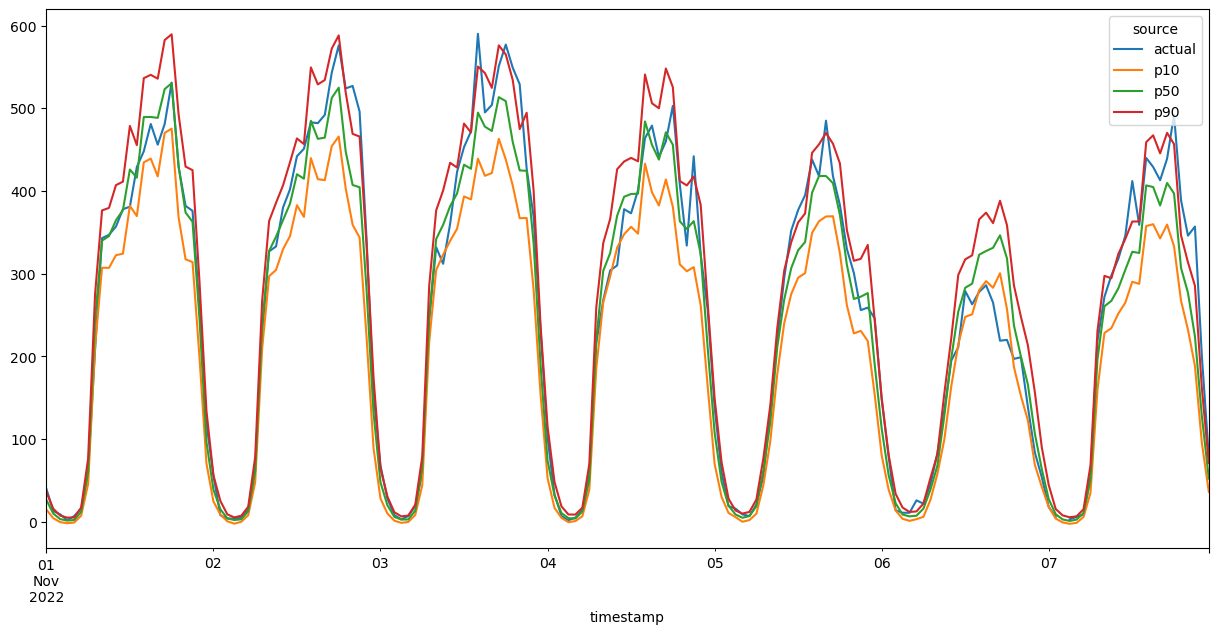

In [134]:
import dateutil
#from dateutil.parser import parse
actuals = df_test_237

results_df = pd.DataFrame(columns=['timestamp', 'value', 'source'])

for index, row in actuals.iterrows():
    clean_timestamp = dateutil.parser.parse(row['timestamp'])
    results_df = pd.concat([results_df, pd.Series({'timestamp' : clean_timestamp , 'value' : row['target_value'], 'source': 'actual'}).to_frame().T], ignore_index=True)
for index, row in forecasts_p10_df.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = pd.concat([results_df, pd.Series({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p10'}).to_frame().T] , ignore_index=True)
for index, row in forecasts_p50_df.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = pd.concat([results_df, pd.Series({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p50'}).to_frame().T] , ignore_index=True)
for index, row in forecasts_p90_df.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = pd.concat([results_df, pd.Series({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p90'}).to_frame().T] , ignore_index=True)

pivot_df = results_df.pivot(columns='source', values='value', index="timestamp")

pivot_df.plot(figsize=(15, 7))

In [92]:
forecast_df = pd.DataFrame(index=pd.date_range(start="2022-11-01 00:00:00", periods = 24 * 7, freq="1H"))
forecast_df = forecast_df.join(forecasts_p50_df)
forecast_df

,Value
2022-11-01 00:00:00,26.562370
2022-11-01 01:00:00,9.943343
2022-11-01 02:00:00,3.285018
2022-11-01 03:00:00,1.540813
2022-11-01 04:00:00,2.242716
...,...
2022-11-07 19:00:00,307.095886
2022-11-07 20:00:00,276.934235
2022-11-07 21:00:00,224.232758
2022-11-07 22:00:00,127.401527


In [109]:
forecast_df = pd.DataFrame(index=pd.date_range(start="2022-11-01T00:00:00", periods = 24 * 7, freq="1H"))
pid = df['item_id'].unique()
for i in pid:
    forecast_response = forecastquery.query_forecast(ForecastArn=forecast_arn, Filters={"item_id": i})
    p50 = pd.DataFrame.from_dict(forecast_response['Forecast']['Predictions']['p50'])
    p50['Timestamp'] = pd.to_datetime(p50['Timestamp'])
    p50 = p50.rename(columns={'Value':i})
    p50 = p50.set_index('Timestamp')
    forecast_df = forecast_df.join(p50)

In [95]:
forecast_df

,48,132,142,161,162,170,186,230,236,237
2022-11-01 00:00:00,71.643364,255.045258,41.130394,32.263248,36.853321,32.633579,60.423935,56.973759,12.686796,26.562370
2022-11-01 01:00:00,40.256618,79.447052,13.337586,14.001607,15.805283,15.870247,27.262753,29.716928,4.001360,9.943343
2022-11-01 02:00:00,24.926325,29.508350,4.496655,4.907254,5.755324,8.524384,18.183872,16.319521,1.404699,3.285018
2022-11-01 03:00:00,19.867657,11.183738,2.737319,3.629344,3.810823,4.927877,8.034961,13.007368,1.017969,1.540813
2022-11-01 04:00:00,19.977037,13.379242,3.190955,4.089968,6.274707,4.751756,14.686769,15.997626,2.481797,2.242716
...,...,...,...,...,...,...,...,...,...,...
2022-11-07 19:00:00,163.581604,349.985199,223.096222,363.101074,276.268921,178.790573,206.458893,212.136902,273.415283,307.095886
2022-11-07 20:00:00,162.876343,391.828613,214.689224,285.810669,244.685471,155.370453,195.428284,191.121765,201.348587,276.934235
2022-11-07 21:00:00,157.252518,376.750366,199.094955,204.671768,183.552277,123.543304,167.591034,174.958267,125.242615,224.232758
2022-11-07 22:00:00,140.696960,375.521881,147.355560,128.662750,111.674332,84.986595,124.377090,154.841156,73.055565,127.401527


In [96]:
forecast_df_path_name = f"{my_bucket_name}/nyc-taxi-trip-data-to-fit/forecast_forecasts.csv"
forecast_df.to_csv(forecast_df_path_name)

In [ ]:
forecast.delete_resource_tree(ResourceArn = dataset_group_arn)
forecast.delete_resource_tree(ResourceArn = ts_dataset_arn)